# Interactive Bayesian Optimization via Preference Information
## Written by Takuma Yamashita, University of Tokyo.  
### Last updated Thursday, 31 Mar 2019.  
In this noteboook we explain how to use class "Interactive_BO". This class enables us to find the optimal parameter by just comparing the presented parameters by the class. This class can deal with three types of comparisons, setwise (pairwise) comparison, linewise comparison and pathwise comparison, which is decided by set the "mode" argument. This class infers the latent utility values of each parameter from a history file and presents the candidates of parameters. Users should compare the presented parameters and restore that information in the history file.

In [1]:
import math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
from  pathwise_bo import Pathwise_BO

### Benchmark Function
Define a test function that is a part of eggholder function.  
The optimal point of this function is (-0.929, 0.762).

In [2]:
def egg_holder(x):
    x = x.reshape(-1,2)

    x1 = x[:,0]*50
    x2 = x[:,1]*50
    return (x2+47) * np.sin(np.sqrt(np.abs(x2+x1/2.+47))) + x1 * np.sin(np.sqrt(np.abs(x1-(x2+47))))

### Documentation    
  - Interactive_BO(bounds, filepath, mode=0, sgm=0.01, theta_fixed=True):  
      - bounds (list): bounsd of parameters  
      - filepath (string): path to a history file
      - mode (int): { mode=0: setwise(pairwise), mode=1: linewise, mode=2: pathwise }
      - sgm (float): hyperparameter of BTL model
      - theta_fixed (bool): fix or estimate hyperparameters of the kernel.
  - Interactive_BO.query(last_selected=[], N=5):
      - last_selected (list of np.array): selected parameter by user at last round
      - N (int): (setwise) size of presented set
           (pathwise) number of pivots
      - return (list of np.array): (setwise) set of candidates
           (linewise) two end points of presented line
           (pathwise) set of pivots

### Setwise Comparison
Get next queries and add information to the history file iteratively.

In [3]:
def iterative_trial():
    truth_opt = np.array([-0.929, 0.762])
    res_list = []
    
    v = egg_holder
    x,y = np.meshgrid(np.linspace(-1,1,50),np.linspace(-1,1,50))
    w = np.array([x.flatten(),y.flatten()]).T
    z = v(w).reshape(50,50) #true value of objective function
    
    # get set candidates
    model = Interactive_BO([[-1,1],[-1,1]], 'param.txt',mode=0, sgm=0.01)
    query = np.array(model.query(N=4))
    
    #plot initial state.
    plt.clf()
    plt.plot(query[:,0],query[:,1],"ro")
    plt.contour(x,y,z)
    plt.show()
    # iterate 10 times
    for i in range(10):
        # choose the subset humans prefered. you can select better candidates as you prefer
        # 'num' is a size of the subset
        num = len(query[v(query)>np.mean(v(query))]) #case1: select candidates better than the mean. 
        #num = np.random.randint(1,N) #case2: select random number of candidates
        #num =3 #case3 select fixed number of candidates
        choice =np.argsort(v(query))[::-1][0:num]
        pl = query[choice] #selected subset
        ql = np.delete(query,choice,axis=0) #unselected subset
        
        #return information to the file. please check the README file about format of the file
        #with open('param.txt','a') as f:
        #    for i,p in enumerate(pl):
        #        if i != (len(pl)-1):
        #            f.writelines(str(list(p)).replace(' ','')+' ')
        #        else:
        #            f.writelines(str(list(p)).replace(' ','')+'>')
        #    for i,q in enumerate(ql):
        #        if i != (len(ql)-1):
        #            f.writelines(str(list(q)).replace(' ','')+' ')
        #        else:
        #            f.writelines(str(list(q)).replace(' ','')+'\n')
        
        #another writing for the history file
        with open('param.txt','a') as f:
            for p in pl:
                for q in ql:
                    f.writelines(str(list(p)).replace(' ','')+'>')
                    f.writelines(str(list(q)).replace(' ','')+'\n')
                    
        
        #get set candidates
        model = Interactive_BO([[-1,1],[-1,1]], 'param.txt', mode=0, sgm=0.01)
        query = np.array(model.query(last_selected=pl,N=4))
        
        #plot results.
        plt.clf()
        plt.subplot(2, 1, 1)
        plt.plot(pl[:,0],pl[:,1],"ro")
        plt.plot(ql[:,0],ql[:,1],"go")
        mean = model._mean(w).reshape(x.shape)
        plt.contour(x,y,mean)
        plt.subplot(2, 1, 2)
        plt.contour(x,y,z)
        plt.show()

        #calculate residuals.
        opt = query[np.argmax(v(query))]
        res = np.linalg.norm(truth_opt-opt)
        res_list.append(res)

    #return transition of residuals.
    return res_list


In [4]:
if os.path.exists('param.txt'):
    os.remove('param.txt')
res_list = iterative_trial()
print("residuals",res_list)

NameError: name 'Interactive_BO' is not defined

### Linewise Comparison
Get next queries and add information to the history file iteratively.

In [3]:
def iterative_trial():
    truth_opt = np.array([-0.929, 0.762])
    res_list = []
    
    v = egg_holder
    x,y = np.meshgrid(np.linspace(-1,1,50),np.linspace(-1,1,50))
    w = np.array([x.flatten(),y.flatten()]).T
    z = v(w).reshape(50,50) #true value of objective function
    query_all = []
    
    #plot initial state.
    plt.clf()
    plt.plot(query[:,0],query[:,1],"r")
    plt.contour(x,y,z)
    plt.show()
    # iterate Bayesian optimization 10 times
    for i in range(10):
　　　　　　 #get slider position
        model = Interactive_BO([[-1,1],[-1,1]], 'param.txt', mode=1, sgm=0.01)
        suggested_parameters, proposed_negative_representives =　model.query()
        # choose the best points along slider.
        path = np.array([np.linspace(suggested_parameters[0,i], suggested_parameters[1,i],100) for i in range(len(suggested_parameters[0]))]).T
        choice = np.argmax(v(path))
        print("answer:",path[choice],v(lpath[choice])) #selected point and it's value.
        
        #return information to the file. please check the README file about format of the file
        with open('param.txt','a') as f:
            f.writelines(str(list(path[choice])).replace(' ','')+'>')
            f.writelines(str(list(query[0])).replace(' ','')+' ')
            f.writelines(str(list(query[1])).replace(' ','')+'\n')
        selected = line[choice]
        query_all.extend([query[0],line[choice],query[1]])
        
        #plot results.
        plt.clf()
        plt.subplot(2, 1, 1)
        plt.plot(query[:,0],query[:,1],"r")
        plt.plot([row[0] for row in query_all],[row[1] for row in query_all],"go")
        plt.plot(selected[0],selected[1],"ro")
        mean = model._mean(w).reshape(x.shape)
        plt.contour(x,y,mean)
        plt.subplot(2, 1, 2)
        plt.contour(x,y,z)
        plt.show()

        #calculate residuals.
        opt = w[np.argmax(mean)]
        res = np.linalg.norm(truth_opt-opt)
        res_list.append(res)

    #return transition of residuals.
    return res_list


In [ ]:
if os.path.exists('param.txt'):
    os.remove('param.txt')
res_list = iterative_trial()
print("residuals",res_list)

### Pathwise Comparison
Get next queries and add information to the history file iteratively.

In [11]:
def iterative_trial():
    truth_opt = np.array([-0.929, 0.762])
    res_list = []
    
    v = egg_holder
    x,y = np.meshgrid(np.linspace(-1,1,10),np.linspace(-1,1,10))
    w = np.array([x.flatten(),y.flatten()]).T
    z = v(w).reshape(10,10) #true value of objective function
    query_all = []
    
    #plot benchmark function.
    plt.clf()
    plt.contour(x,y,z)
    plt.show()
    
    # iterate Bayesian optimization 10 times
    for i in range(10):
        # get slider pivots and representive points.
        model = Pathwise_BO([[0,1],[0,1]], 'history.txt', sgm=0.01)
        suggested_parameters, proposed_negative_representives = model.query()
        suggested_parameters = -1 + 2*np.array(suggested_parameters)
        path = np.array([np.array([np.linspace(suggested_parameters[i][j],suggested_parameters[i+1][j],10) for j in range(2)]).T for i in range(9)]).reshape((90,2))
    
        # choose the best points along slider.
        choice = np.argmax(v(path))
        print("answer:",path[choice],v(path[choice])) #selected point and it's value.
        
        #calculate residuals.
        opt = path[choice]
        res = np.linalg.norm(truth_opt-opt)
        res_list.append(res)
        negative_representives = proposed_negative_representives #representive negative points
        
        #return information to the file. please check the README file about format of the file
        with open('history.txt','a') as f:
            f.writelines(str(list(path[choice])).replace(' ','')+'>')
            f.writelines(str(list(negative_representives[0])).replace(' ','')+' ')
            f.writelines(str(list(negative_representives[1])).replace(' ','')+'\n')
        selected = path[choice]
        #query_all.extend([query[0],line[choice],query[1]])
        
        #plot results.
        plt.clf()
        plt.subplot(2, 1, 1)
        plt.plot(path[:,0],path[:,1],"r")
        plt.plot(selected[0],selected[1],"ro")
        plt.plot(negative_representives[0][0],negative_representives[0][1],"go")
        plt.plot(negative_representives[1][0],negative_representives[1][1],"go")
        if (i!=0):
            mean = model.mean(w).reshape(x.shape)
            ei = model.expected_improvement(w).reshape(x.shape)
            plt.contour(x,y,ei)
        plt.subplot(2, 1, 2)
        plt.contour(x,y,z)
        plt.show()

    #return transition of residuals.
    return res_list

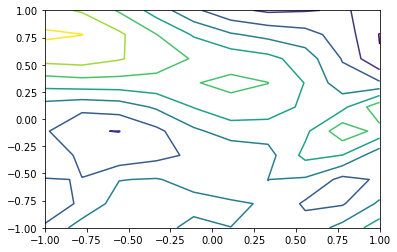

/Users/yamashita/UT/mlab/code/preference_bayesian_optimization/general/interactive_bo_general.py:124: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(frac/denomi))


self.fMAP [ 0.02508343 -0.02508343  0.02508343 -0.02508343  0.02508343  0.02508343
  0.02508343 -0.02508343]
self._theta [0.35  0.35  0.005 0.005]
hello
answer: [ 1. -1.] [44.98954343]


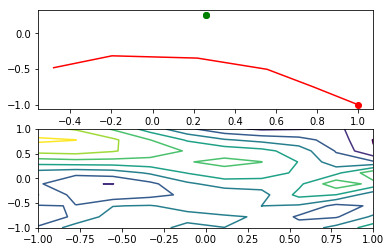

self.fMAP [-0.02611516  0.02611516  0.02611516 -0.02611516  0.02611516  0.02611516
  0.02611516 -0.02611516]
self._theta [0.35  0.35  0.005 0.005]
hello
answer: [ 1. -1.] [44.98954343]


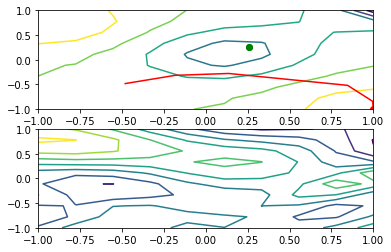

self.fMAP [-0.02706507 -0.02706507  0.02706507  0.02706507  0.02706507  0.02706507
  0.02706507 -0.02706507]
self._theta [0.35  0.35  0.005 0.005]
hello
answer: [ 1. -1.] [44.98954343]


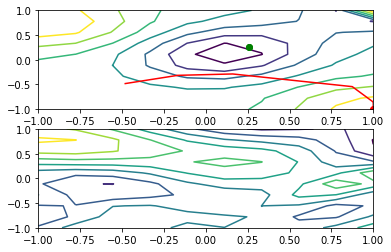

self.fMAP [ 0.02794349 -0.02794349  0.02794349 -0.02794349  0.02794349  0.02794349
  0.02794349 -0.02794349]
self._theta [0.35  0.35  0.005 0.005]
hello
answer: [ 1. -1.] [44.98954343]


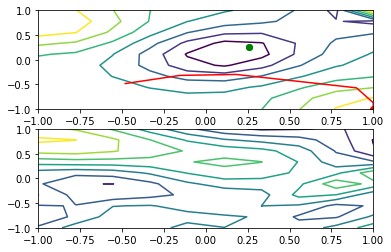

self.fMAP [-0.02875891  0.02875891  0.02875891 -0.02875891  0.02875891  0.02875891
  0.02875891 -0.02875891]
self._theta [0.35  0.35  0.005 0.005]
hello
answer: [ 1. -1.] [44.98954343]


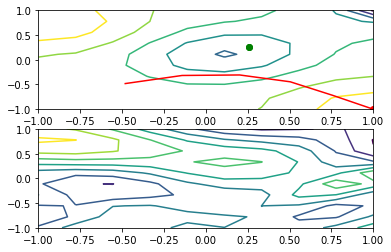

self.fMAP [-0.02951843 -0.02951843  0.02951843  0.02951843  0.02951843  0.02951843
  0.02951843 -0.02951843]
self._theta [0.35  0.35  0.005 0.005]
hello
answer: [ 1. -1.] [44.98954343]


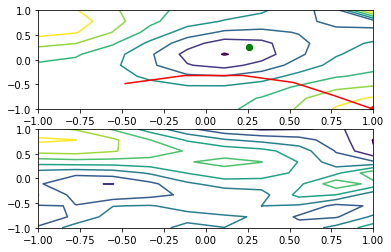

self.fMAP [ 0.03022799 -0.03022799  0.03022799 -0.03022799  0.03022799  0.03022799
  0.03022799 -0.03022799]
self._theta [0.35  0.35  0.005 0.005]
hello
answer: [ 1. -1.] [44.98954343]


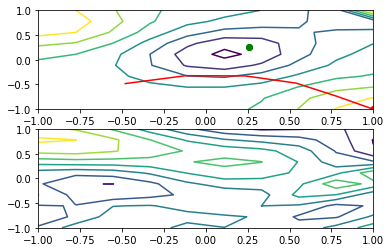

self.fMAP [-0.02962207  0.02962207  0.02962207 -0.02962207  0.02962207  0.02962207
  0.02962207 -0.02962207]
self._theta [0.35  0.35  0.005 0.005]
hello
answer: [ 1. -1.] [44.98954343]


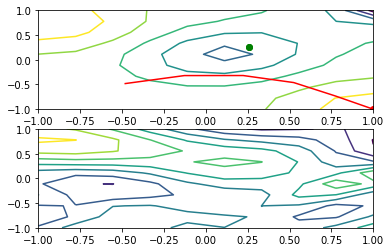

self.fMAP [-0.03029208 -0.03029208  0.03029208  0.03029208  0.03029208  0.03029208
  0.03029208 -0.03029208]
self._theta [0.35  0.35  0.005 0.005]
hello
answer: [ 1. -1.] [44.98954343]


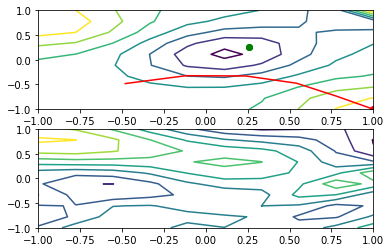

self.fMAP [ 0.03092201 -0.03092201  0.03092201 -0.03092201  0.03092201  0.03092201
  0.03092201 -0.03092201]
self._theta [0.35  0.35  0.005 0.005]
hello
answer: [ 1. -1.] [44.98954343]


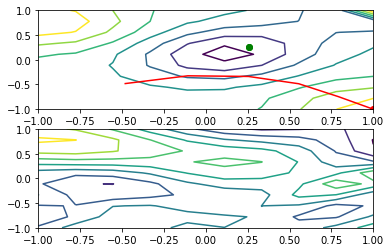

residuals [2.6126011942123886, 2.6126011942123886, 2.6126011942123886, 2.6126011942123886, 2.6126011942123886, 2.6126011942123886, 2.6126011942123886, 2.6126011942123886, 2.6126011942123886, 2.6126011942123886]


In [12]:
if os.path.exists('param.txt'):
    os.remove('param.txt')
res_list = iterative_trial()
print("residuals",res_list)